# FOOTBALL HACKATHON


# 0.0. IMPORTS

In [3]:
import pandas                                                      as pd
import seaborn                                                     as sns

from matplotlib                    import pyplot                   as plt
from IPython.core.display          import HTML
import sweetviz                                                    as sv
#import umap.umap_                                                  as umap
import umap


from sklearn                       import ensemble                 as en
from sklearn.metrics               import r2_score
from sklearn.svm import SVC


from catboost                      import CatBoostClassifier       as cb
from xgboost                       import XGBClassifier 


import warnings

warnings.filterwarnings("ignore")

## 0.1. Helper Functions 

In [2]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)

In [4]:
my_settings()

In [5]:
def descriptive_stats(df): 
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m




## 0.2. Load Dataset

In [6]:
test_dataset = pd.read_csv(r'../data/raw/test.csv')

In [7]:
test_dataset.head()

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,14785,16,draw,team1,7.00,4.00,4.00,0.32,0.44,0.00,...,0.27,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33
1,15125,2,draw,team1,9.00,11.00,11.00,0.56,0.60,0.00,...,0.35,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50
2,13095,16,loser,team2,10.00,19.00,19.00,0.20,0.30,0.00,...,0.35,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27
3,6079,16,loser,team1,11.00,3.00,9.00,0.34,0.30,0.00,...,0.50,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29
4,16584,11,winner,team1,5.00,4.00,4.00,0.59,0.70,0.20,...,0.40,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44


In [8]:
train_dataset = pd.read_csv(r'../data/raw/train.csv')

In [9]:
submission_dataset = pd.read_csv(r'../data/raw/sample_submission_wBWLI0s.csv')

In [10]:
submission_dataset.head()

,row_id,rating_num
0,14785,7
1,15125,7
2,13095,7
3,6079,7
4,16584,7


In [11]:
df_test_total = pd.merge(test_dataset, submission_dataset , how = 'left' , on = 'row_id' )

In [12]:
df_test_total

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19,rating_num
0,14785,16,draw,team1,7.00,4.00,4.00,0.32,0.44,0.00,...,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33,7
1,15125,2,draw,team1,9.00,11.00,11.00,0.56,0.60,0.00,...,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50,7
2,13095,16,loser,team2,10.00,19.00,19.00,0.20,0.30,0.00,...,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27,7
3,6079,16,loser,team1,11.00,3.00,9.00,0.34,0.30,0.00,...,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29,7
4,16584,11,winner,team1,5.00,4.00,4.00,0.59,0.70,0.20,...,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,21259,15,loser,team1,7.00,11.00,11.00,0.46,0.60,0.00,...,0.29,0.34,0.57,0.72,0.68,0.34,0.40,0.55,0.28,7
8770,9371,2,draw,team1,4.00,16.00,16.00,0.34,0.40,0.20,...,0.16,0.17,0.80,0.45,0.44,0.09,0.42,0.44,0.14,7
8771,23226,2,loser,team2,4.00,1.00,1.00,0.44,0.36,0.00,...,0.18,0.31,0.59,0.48,0.80,0.09,0.25,0.36,0.38,7
8772,26623,11,winner,team1,10.00,1.00,1.00,0.46,0.54,0.00,...,0.14,0.23,0.61,0.36,0.33,0.05,0.43,0.50,0.09,7


#  2.0. Description Data

In [13]:
df1 = train_dataset.copy()

In [14]:
df1.head()

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.00,winner,team1,8,7.00,7.00,0.32,0.48,...,0.19,0.13,0.10,0.60,0.34,0.35,0.03,0.29,0.31,0.20
1,3,16,6.50,loser,team2,8,3.00,9.00,0.46,0.42,...,0.19,0.17,0.27,0.61,0.53,0.47,0.05,0.33,0.38,0.30
2,4,4,8.50,loser,team1,5,11.00,11.00,0.68,0.44,...,0.31,0.25,0.21,0.56,0.69,0.44,0.22,0.41,0.57,0.44
3,5,13,8.00,loser,team2,4,17.00,17.00,0.68,0.58,...,0.28,0.16,0.21,0.53,0.37,0.53,0.10,0.42,0.33,0.24
4,7,11,3.50,draw,team1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31


In [15]:
df1.columns

Index(['row_id', 'scout_id', 'rating_num', 'winner', 'team', 'competitionId',
       'player_position_1', 'player_position_2', 'player_height',
       'player_weight',
       ...
       'team2_defensive_derived_var_10', 'team2_offensive_derived_var_11',
       'team2_offensive_derived_var_12', 'team2_offensive_derived_var_13',
       'team2_offensive_derived_var_14', 'team2_defensive_derived_var_15',
       'team2_offensive_derived_var_16', 'team2_defensive_derived_var_17',
       'team2_offensive_derived_var_18', 'team2_offensive_derived_var_19'],
      dtype='object', length=800)

In [16]:
df1.nunique()

row_id                            20453
scout_id                             21
rating_num                           13
winner                                3
team                                  2
                                  ...  
team2_defensive_derived_var_15     2798
team2_offensive_derived_var_16     3624
team2_defensive_derived_var_17     1387
team2_offensive_derived_var_18     3509
team2_offensive_derived_var_19      609
Length: 800, dtype: int64

## 2.1. Dimensions Data

In [17]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 20453
Number of columns: 800


## 2.2. Data Types

In [18]:
df1.dtypes

row_id                              int64
scout_id                            int64
rating_num                        float64
winner                             object
team                               object
                                   ...   
team2_defensive_derived_var_15    float64
team2_offensive_derived_var_16    float64
team2_defensive_derived_var_17    float64
team2_offensive_derived_var_18    float64
team2_offensive_derived_var_19    float64
Length: 800, dtype: object

## 2.3. Check NA

In [19]:
df1.isna().sum()

row_id                               0
scout_id                             0
rating_num                           0
winner                               0
team                                 0
                                  ... 
team2_defensive_derived_var_15    1427
team2_offensive_derived_var_16    1427
team2_defensive_derived_var_17    1427
team2_offensive_derived_var_18    1427
team2_offensive_derived_var_19    1427
Length: 800, dtype: int64

## 2.4. Replace NA

In [20]:
df1 = df1.fillna(0) 

## 2.5. Changes dtypes

## 2.6. Descriptive Statistics

In [112]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64' , 'float64'])

###  2.6.1. Numerical Attributs

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 2.6.2 Categorical Attributs


In [20]:
 #Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(2,1,1)
age_hist = sns.histplot(df1['winer'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(2,1,2)
hap_hist = sns.histplot(df1['health_annual_paid'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');



ValueError: Length mismatch: Expected axis has 1603 elements, new values have 9 elements

# 3.0. Variable Filtering

In [21]:
df2 = df1.copy()

# 4.0. Feature Engeneering

In [22]:
df3 = df2.copy()

In [23]:
df3.head()

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.00,winner,team1,8,7.00,7.00,0.32,0.48,...,0.19,0.13,0.10,0.60,0.34,0.35,0.03,0.29,0.31,0.20
1,3,16,6.50,loser,team2,8,3.00,9.00,0.46,0.42,...,0.19,0.17,0.27,0.61,0.53,0.47,0.05,0.33,0.38,0.30
2,4,4,8.50,loser,team1,5,11.00,11.00,0.68,0.44,...,0.31,0.25,0.21,0.56,0.69,0.44,0.22,0.41,0.57,0.44
3,5,13,8.00,loser,team2,4,17.00,17.00,0.68,0.58,...,0.28,0.16,0.21,0.53,0.37,0.53,0.10,0.42,0.33,0.24
4,7,11,3.50,draw,team1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31


In [24]:
dict_winner = {'winner': 2, 'draw' : 1, 'loser':0}
df3['winner'] = df3['winner'].map(dict_winner)
df3['winner'].value_counts()

2    8735
0    6442
1    5276
Name: winner, dtype: int64

In [25]:
dict_team = {'team1': 1, 'team2':0}
df3['team'] = df3['team'].map(dict_team)
df3['team'].value_counts()

1    10306
0    10147
Name: team, dtype: int64

In [24]:
dict_winner_t = {'winner': 2, 'draw' : 1, 'loser':0}
df_test_total['winner'] = df_test_total['winner'].map(dict_winner_t)
df_test_total['winner'].value_counts()

2    3258
0    3236
1    2280
Name: winner, dtype: int64

In [25]:
dict_team_t = {'team1': 1, 'team2':0}
df_test_total['team'] = df_test_total['team'].map(dict_team_t)
df_test_total['team'].value_counts()

1.00    4563
0.00    4210
Name: team, dtype: int64

## 4.1. Feature Creation

# 5.0. EDA (Exploratory Data Analysis)

In [27]:
df4 = df3.copy()

In [116]:
# Generate report
report = sv.analyze(df4, target_feat='rating_num')

# Save and show on browser
report.show_html(filepath='../reports/sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.

Done! Use 'show' commands to display/save.   |██████████████████████████████████████████| [100%]   00:00 -> (00:00 left)


Report ../reports/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Univariable 

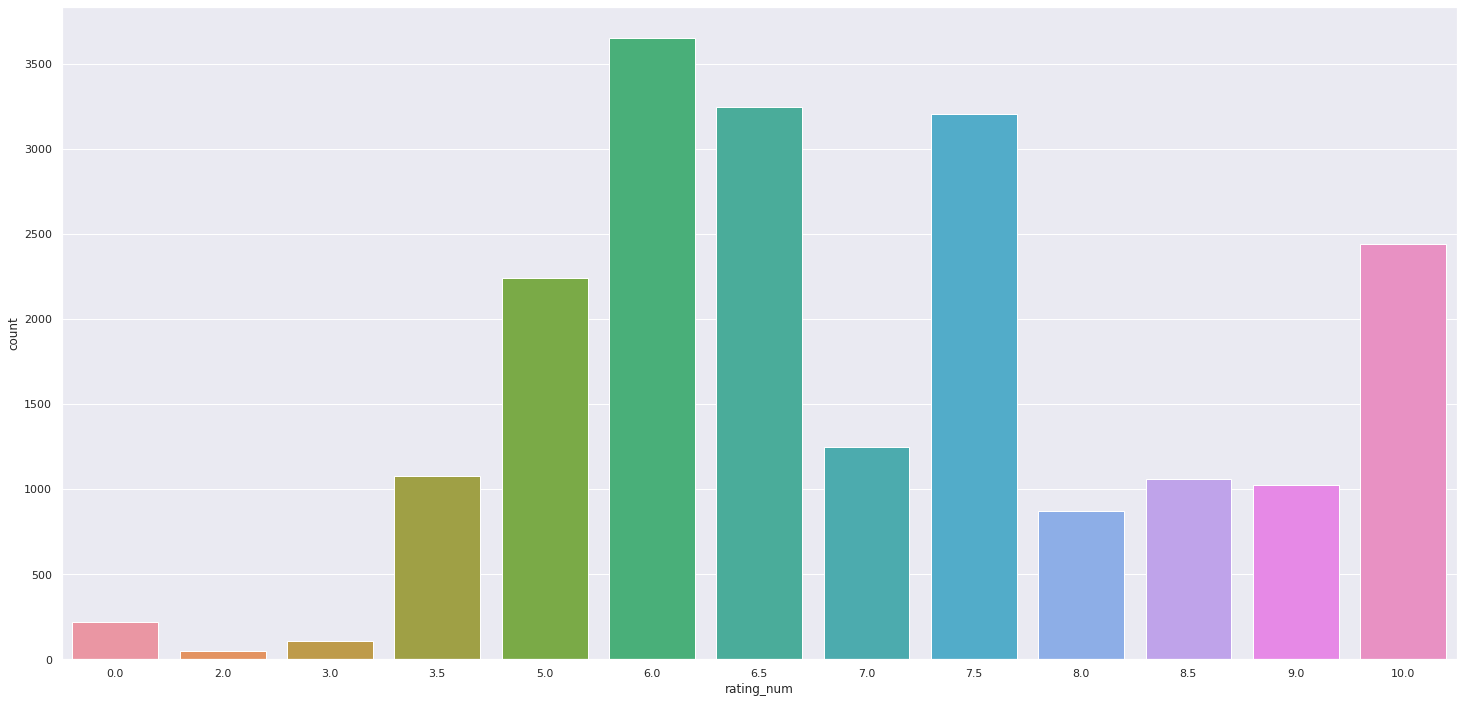

In [29]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="rating_num", data=df4)

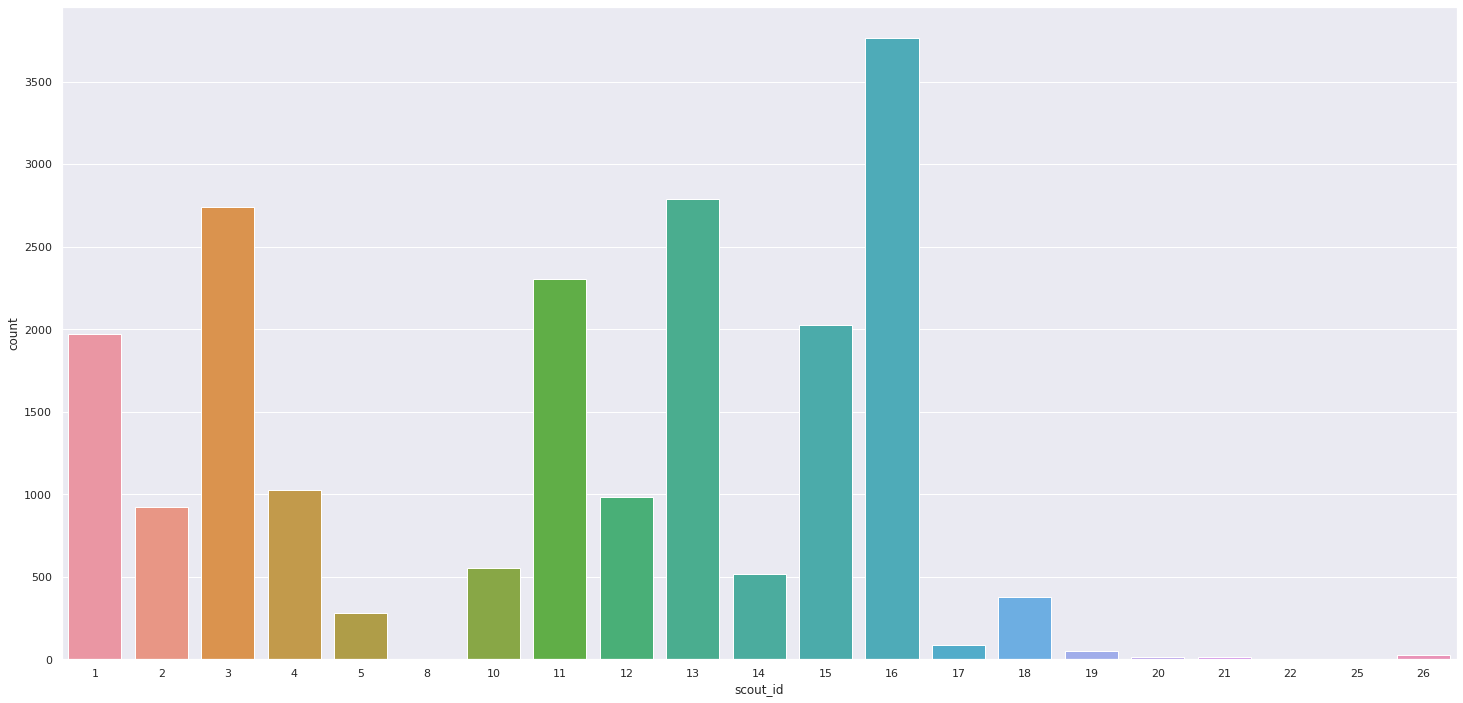

In [30]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="scout_id", data=df4)

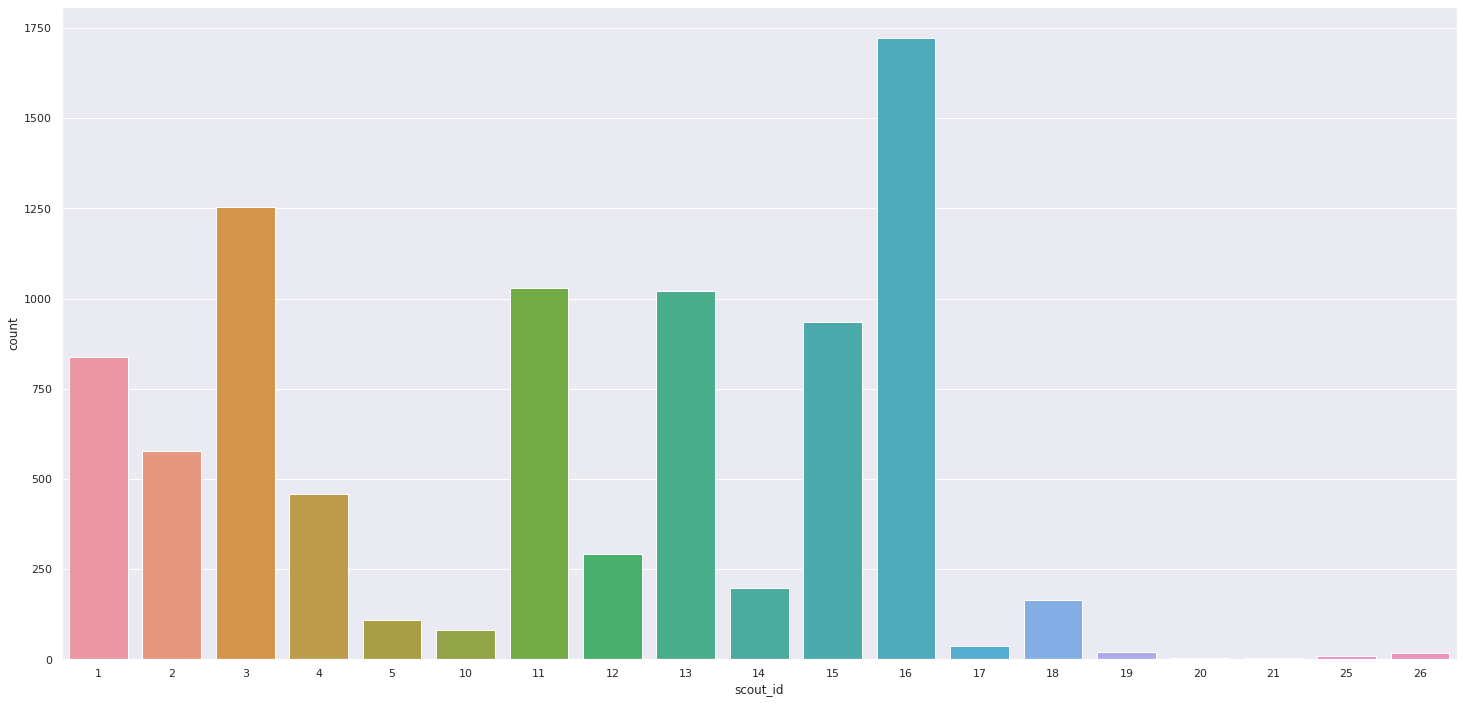

In [31]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="scout_id", data=df_test_total)

[ 8  5  4  7  9 10  6 11 14 15]


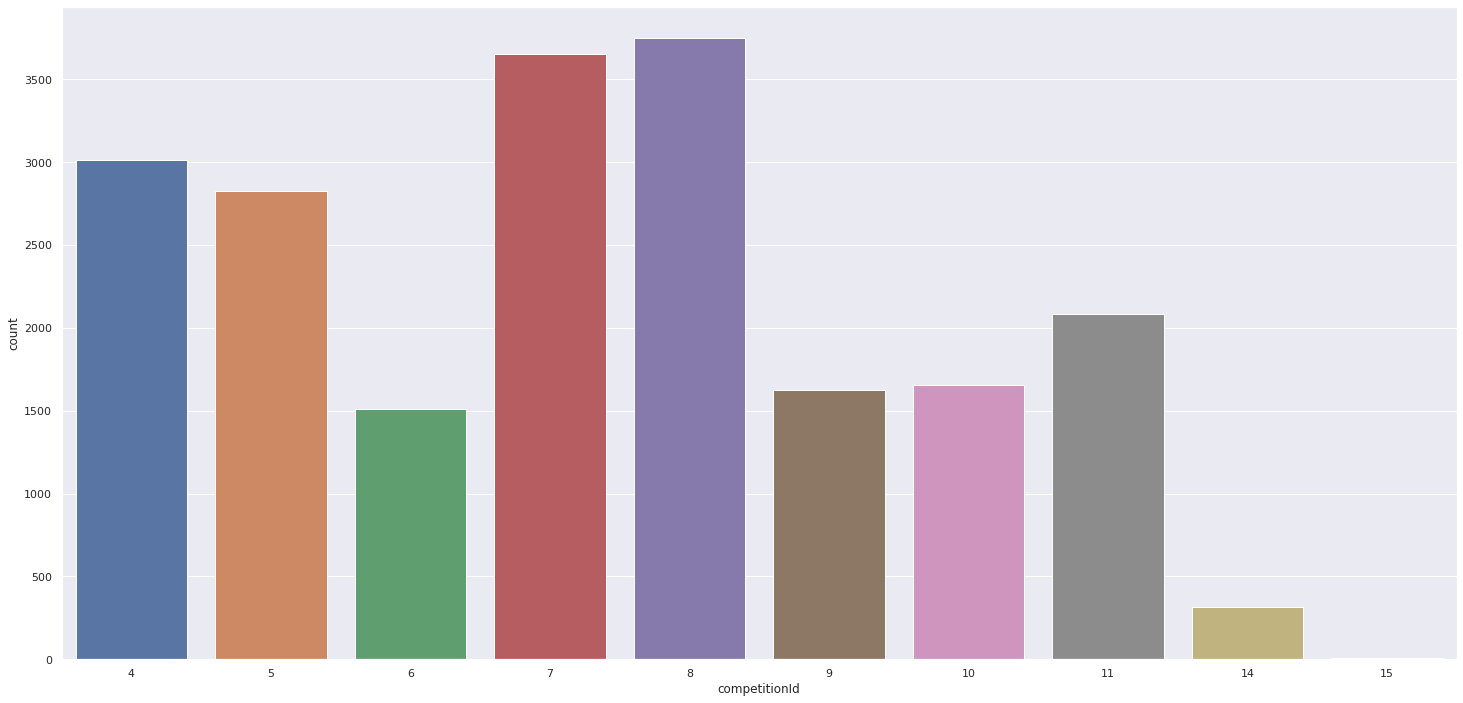

In [33]:
print(df4.competitionId.unique())
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="competitionId", data=df4)

[ 7.  9. 10. 11.  5.  6.  4.  8. 15. 14. nan]


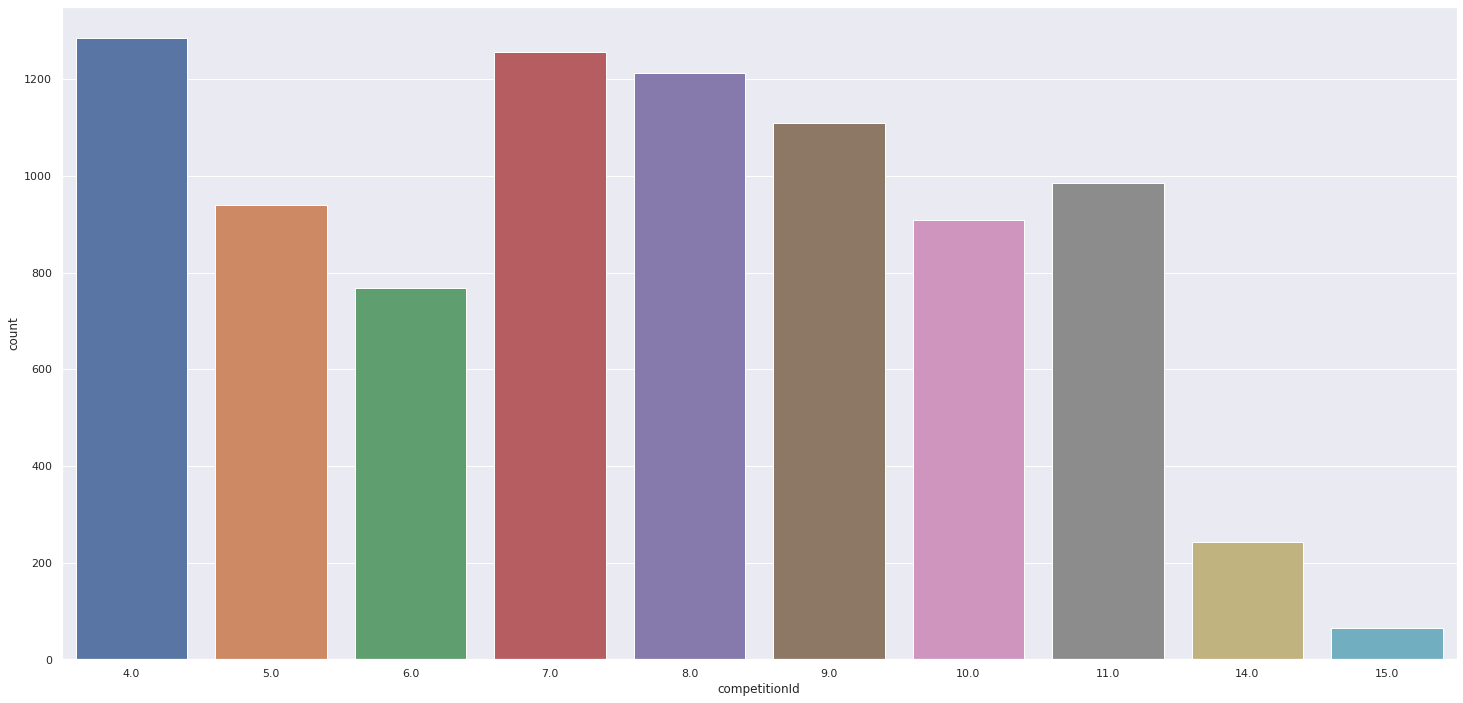

In [34]:
print(df_test_total.competitionId.unique())
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="competitionId", data=df_test_total)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0]


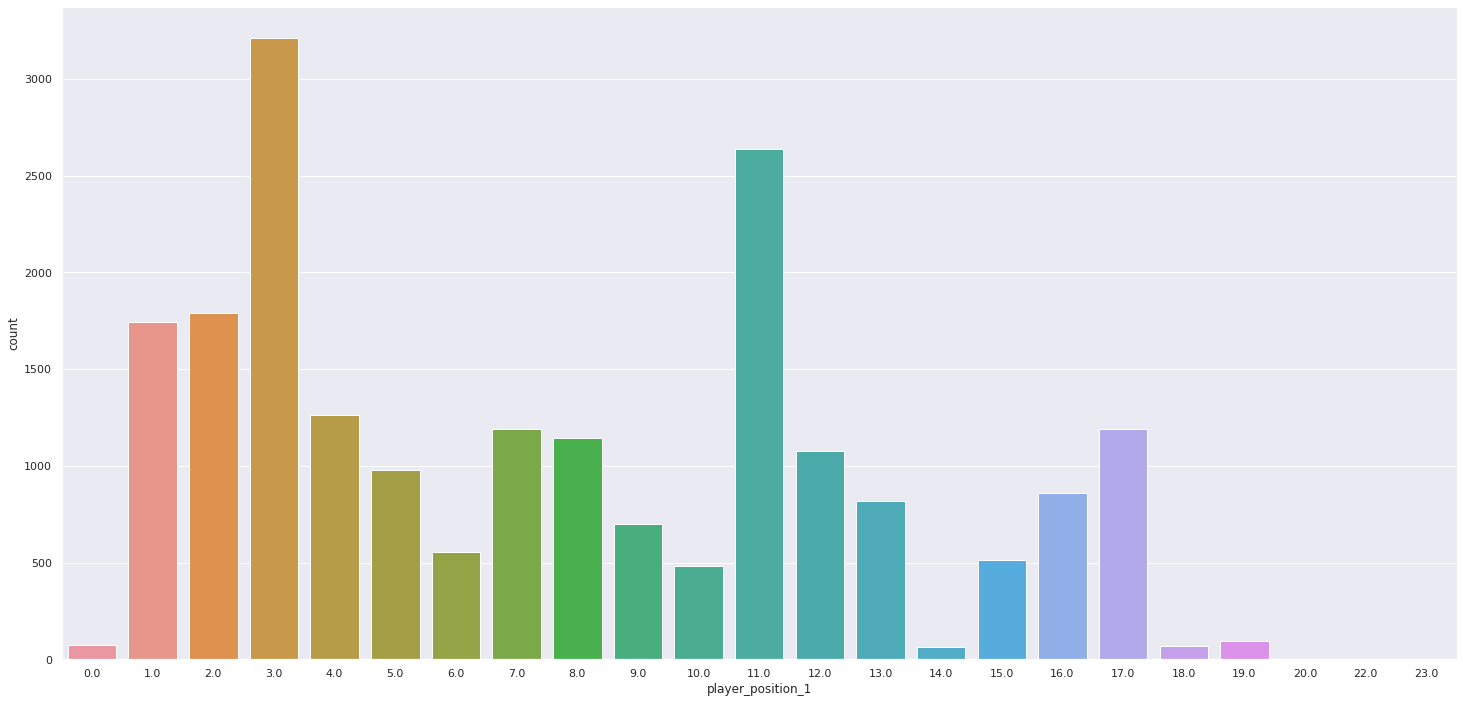

In [35]:
print(sorted(df4.player_position_1.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_1", data=df4)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, nan, 20.0, 21.0, 23.0]


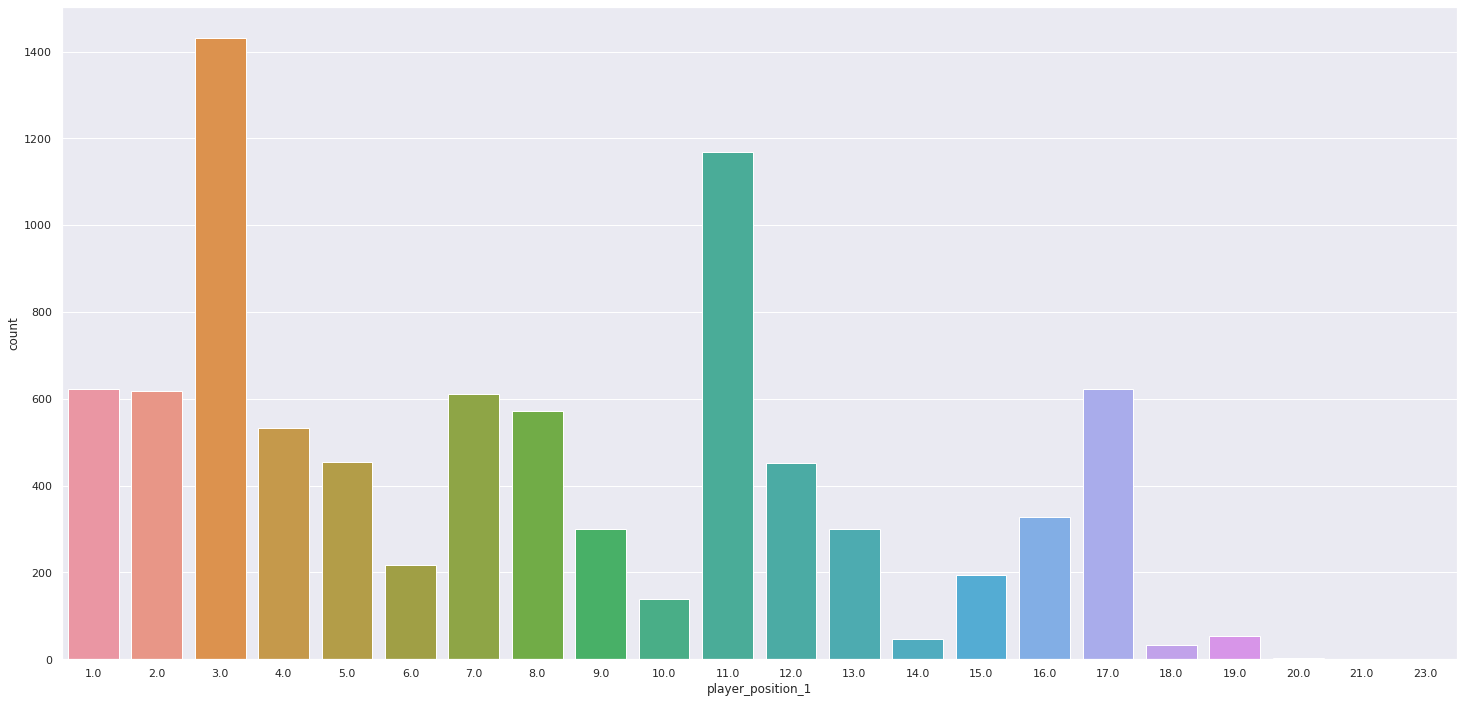

In [36]:
print(sorted(df_test_total.player_position_1.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_1", data=df_test_total)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0]


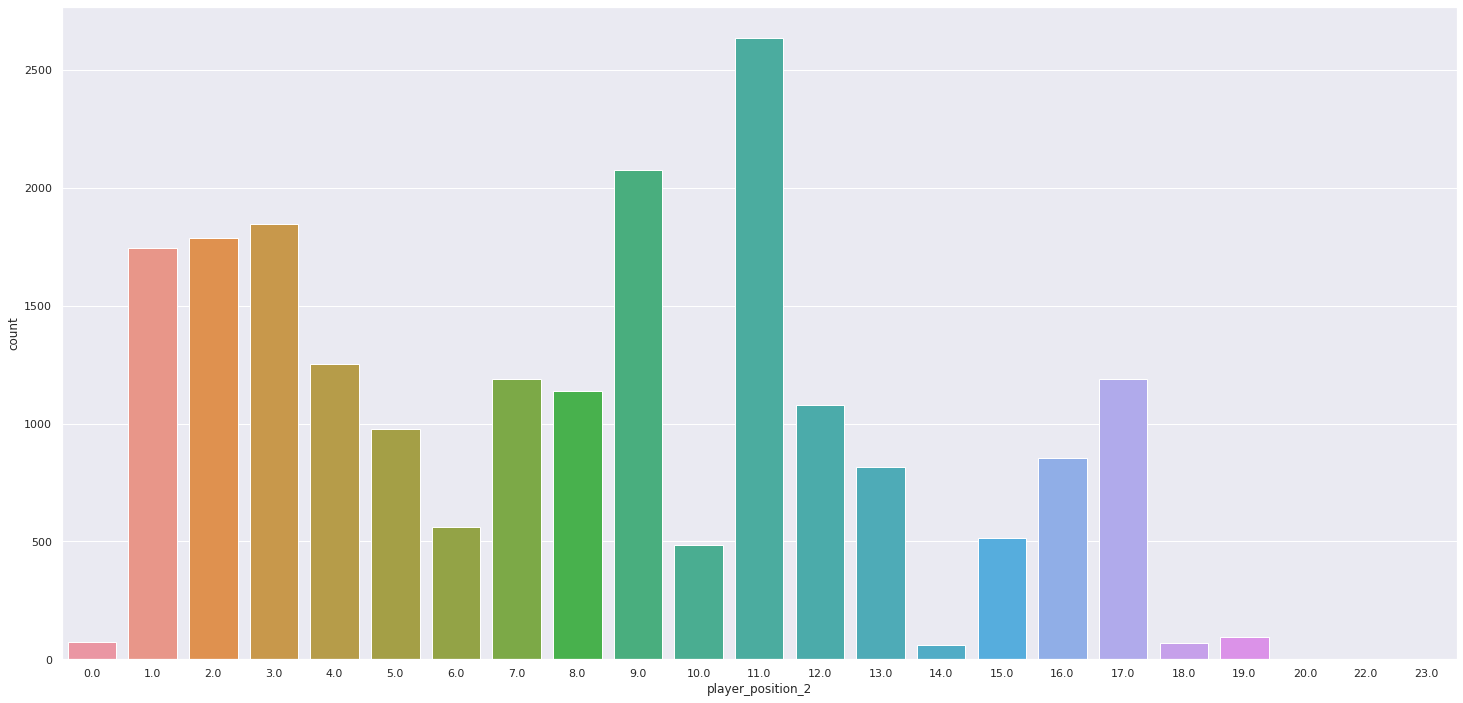

In [37]:
print(sorted(df4.player_position_2.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_2", data=df4)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, nan, 20.0, 21.0, 23.0]


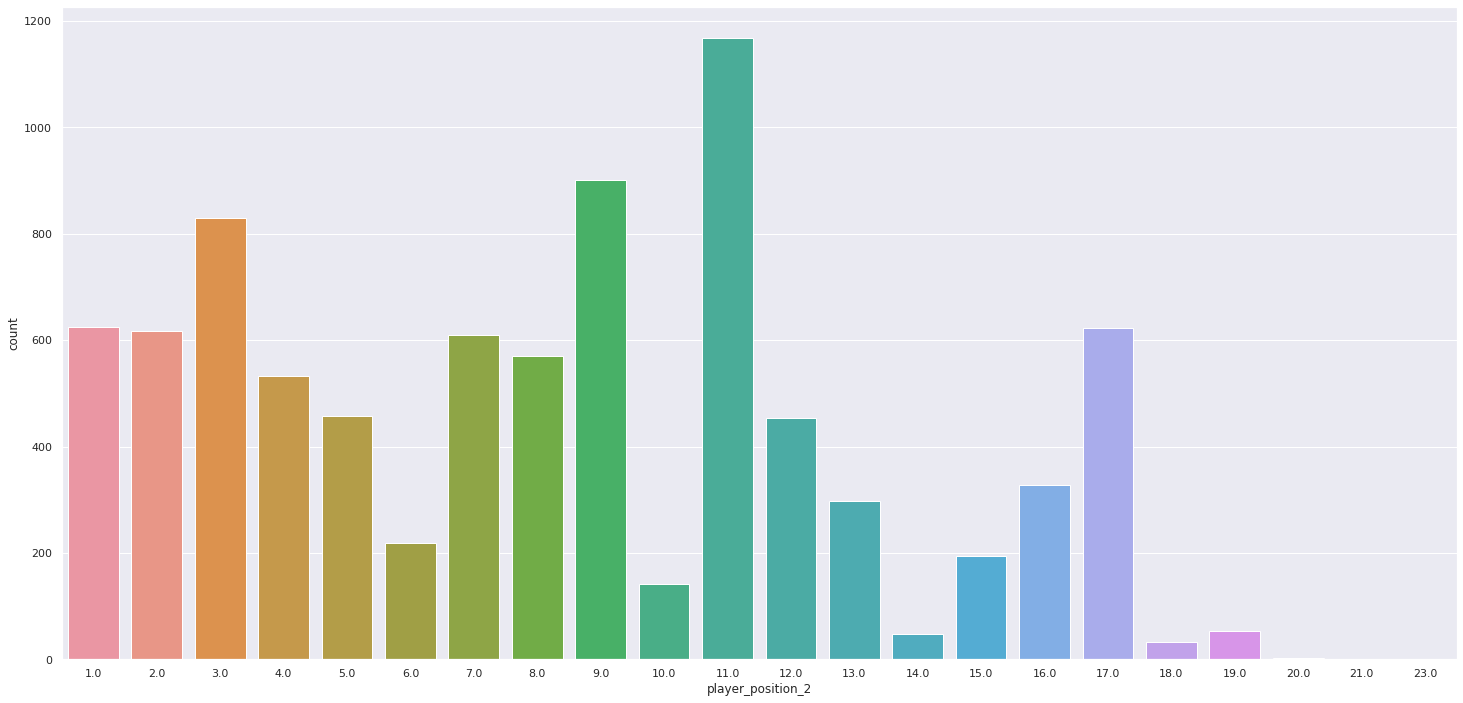

In [38]:
print(sorted(df_test_total.player_position_2.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_2", data=df_test_total)

<AxesSubplot:xlabel='player_height', ylabel='Count'>

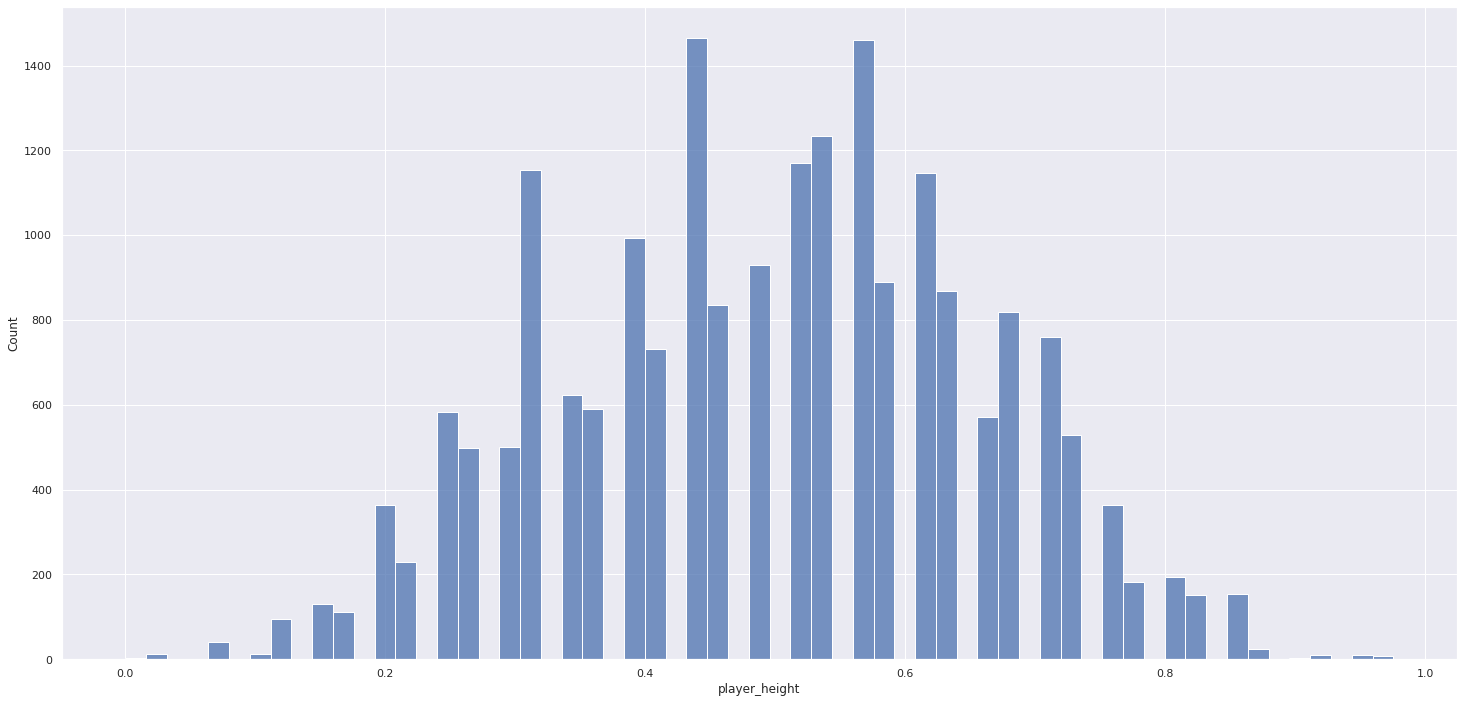

In [39]:
sns.histplot(data=df4, x="player_height")

<AxesSubplot:xlabel='player_height', ylabel='Count'>

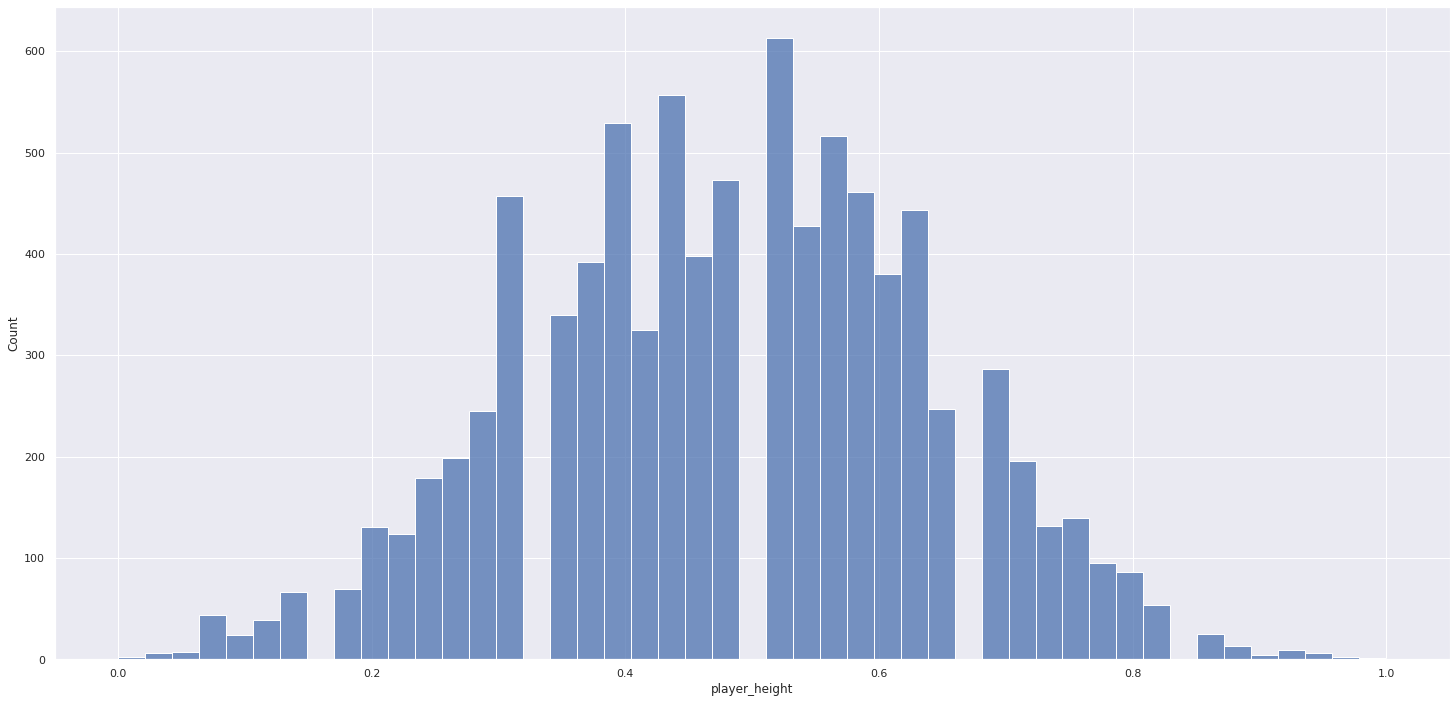

In [40]:
sns.histplot(data=df_test_total, x="player_height")

## 5.2. UMAP

In [29]:
df4.head(30)

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.00,2,1,8,7.00,7.00,0.32,0.48,...,0.19,0.13,0.10,0.60,0.34,0.35,0.03,0.29,0.31,0.20
1,3,16,6.50,0,0,8,3.00,9.00,0.46,0.42,...,0.19,0.17,0.27,0.61,0.53,0.47,0.05,0.33,0.38,0.30
2,4,4,8.50,0,1,5,11.00,11.00,0.68,0.44,...,0.31,0.25,0.21,0.56,0.69,0.44,0.22,0.41,0.57,0.44
3,5,13,8.00,0,0,4,17.00,17.00,0.68,0.58,...,0.28,0.16,0.21,0.53,0.37,0.53,0.10,0.42,0.33,0.24
4,7,11,3.50,1,1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31
5,8,11,3.50,1,1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31
6,9,15,7.00,2,0,7,10.00,10.00,0.61,0.46,...,0.26,0.24,0.36,0.53,0.65,0.56,0.19,0.52,0.47,0.39
7,10,4,7.50,0,1,7,3.00,9.00,0.24,0.34,...,0.41,0.18,0.00,0.80,0.41,0.29,0.02,0.49,0.34,0.61
8,11,16,7.50,2,1,7,8.00,8.00,0.39,0.22,...,0.45,0.16,0.05,0.76,0.59,0.58,0.07,0.46,0.56,0.21
9,12,3,6.50,1,0,5,3.00,3.00,0.61,0.58,...,0.57,0.18,0.21,0.61,0.46,0.32,0.06,0.36,0.42,0.43


In [107]:
# training dataset 
X = df4.drop(columns=['rating_num'], axis = 1)
Y = df4['rating_num']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(X,Y)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

In [108]:
%%time
# reduzer dimensionality
reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(df_leaf , y = Y)
embedding = reducer.fit(df_leaf)
#df_tree = pd.DataFrame()


CPU times: user 28 s, sys: 1.77 s, total: 29.8 s
Wall time: 13.1 s


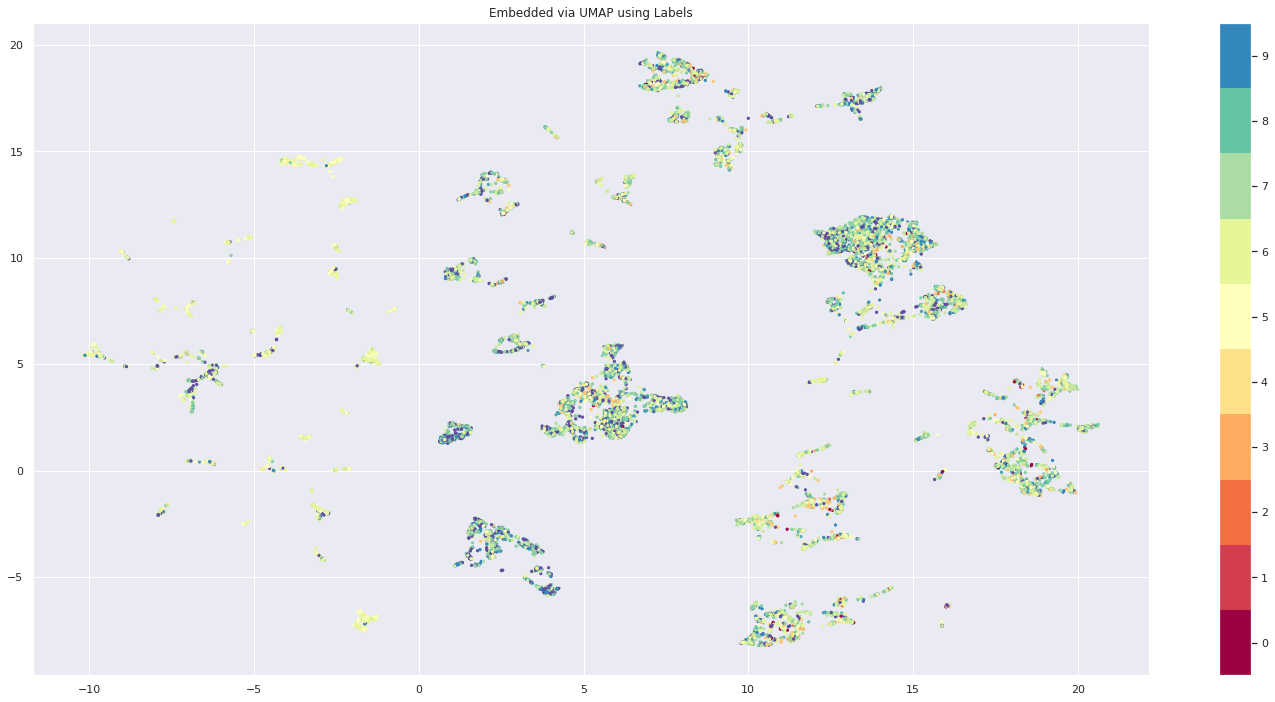

In [109]:
#plt.scatter(*embedding.T, s=0.1, c=Y, cmap='Spectral', alpha=1.0)
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], s= 5, c=Y, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(Y)
plt.title( 'Embedded via UMAP using Labels');

In [76]:
# test dataset 
X_test = df_test_f.drop(columns=['rating_num'], axis = 1)
Y_test = df_test_f['rating_num']

In [86]:

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(X_test,Y_test)

# dataframe Leaf
df_leaf_test = pd.DataFrame(rf_model.apply(X))

In [88]:
%%time
# reduzer dimensionality
reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(df_leaf , y = Y)
embedding_test = reducer.fit(df_leaf_test)
#df_tree = pd.DataFrame()

CPU times: user 32.4 s, sys: 1.71 s, total: 34.1 s
Wall time: 27.5 s


# 6.0. Data Preparation

In [32]:
df5 = df_tree_1.copy()

# 7.0. Feature Selection

In [42]:
df6 = df4.copy()

### Validation Split

In [43]:
X = df6.drop(['rating_num'], axis = 1).copy() 
y = df6['rating_num']

#Split Train into Val:
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

NameError: name 'ms' is not defined

In [ ]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = x_train 
y_train_n = y_train.values 
forest.fit( x_train_n, y_train_n )

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis= 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df =pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr= std[indices], align= 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 8.0. Hyperparameter Fine-Tunning

In [34]:
df7 = df6.copy()

# 9.0. Model Training 

In [39]:
df8 = df_tree_1.copy()
df_test_f = df_test_total.copy()

In [75]:
df_test_f = df_test_f.fillna(0) 

## SVM

In [92]:
# Model definition
svm = SVC(random_state=42, verbose=False )

# Model training
svm.fit( embedding.embedding_ , Y )

# Model transform
test_embedding = svm.transform(embedding_test.embedding_)


ValueError: Unknown label type: 'continuous'

In [ ]:
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=Y, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24);

In [ ]:
# perfomance
result_catboost = r2_score(Y_test ,yhat_cb)

## Catboost


In [102]:
X_test

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,14785,16,1,1.00,7.00,4.00,4.00,0.32,0.44,0.00,...,0.27,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33
1,15125,2,1,1.00,9.00,11.00,11.00,0.56,0.60,0.00,...,0.35,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50
2,13095,16,0,0.00,10.00,19.00,19.00,0.20,0.30,0.00,...,0.35,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27
3,6079,16,0,1.00,11.00,3.00,9.00,0.34,0.30,0.00,...,0.50,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29
4,16584,11,2,1.00,5.00,4.00,4.00,0.59,0.70,0.20,...,0.40,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,21259,15,0,1.00,7.00,11.00,11.00,0.46,0.60,0.00,...,0.37,0.29,0.34,0.57,0.72,0.68,0.34,0.40,0.55,0.28
8770,9371,2,1,1.00,4.00,16.00,16.00,0.34,0.40,0.20,...,0.38,0.16,0.17,0.80,0.45,0.44,0.09,0.42,0.44,0.14
8771,23226,2,0,0.00,4.00,1.00,1.00,0.44,0.36,0.00,...,0.15,0.18,0.31,0.59,0.48,0.80,0.09,0.25,0.36,0.38
8772,26623,11,2,1.00,10.00,1.00,1.00,0.46,0.54,0.00,...,0.24,0.14,0.23,0.61,0.36,0.33,0.05,0.43,0.50,0.09


In [105]:
# Model definition
catboost = cb( random_state=42, verbose=False )

# Model training
catboost.fit( embedding.embedding_ , Y )

# Model prediction 
yhat_cb = catboost.score( X_test , Y_test )



In [106]:
yhat_cb

0.0

## Random Forest Regression

In [83]:
X_test

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,14785,16,1,1.00,7.00,4.00,4.00,0.32,0.44,0.00,...,0.27,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33
1,15125,2,1,1.00,9.00,11.00,11.00,0.56,0.60,0.00,...,0.35,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50
2,13095,16,0,0.00,10.00,19.00,19.00,0.20,0.30,0.00,...,0.35,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27
3,6079,16,0,1.00,11.00,3.00,9.00,0.34,0.30,0.00,...,0.50,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29
4,16584,11,2,1.00,5.00,4.00,4.00,0.59,0.70,0.20,...,0.40,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,21259,15,0,1.00,7.00,11.00,11.00,0.46,0.60,0.00,...,0.37,0.29,0.34,0.57,0.72,0.68,0.34,0.40,0.55,0.28
8770,9371,2,1,1.00,4.00,16.00,16.00,0.34,0.40,0.20,...,0.38,0.16,0.17,0.80,0.45,0.44,0.09,0.42,0.44,0.14
8771,23226,2,0,0.00,4.00,1.00,1.00,0.44,0.36,0.00,...,0.15,0.18,0.31,0.59,0.48,0.80,0.09,0.25,0.36,0.38
8772,26623,11,2,1.00,10.00,1.00,1.00,0.46,0.54,0.00,...,0.24,0.14,0.23,0.61,0.36,0.33,0.05,0.43,0.50,0.09


In [95]:
# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(embedding.embedding_,Y)

# prediction
yhat_RFR = rf_model.predict(embedding_test.embedding_)

# perfomance
result_RFR = r2_score(embedding_test.embedding_ , yhat_RFR)

ValueError: Found input variables with inconsistent numbers of samples: [8774, 20453]

## XGboost

In [84]:
# model definition
xgb_model = XGBClassifier()

# model fit
model_xgb = xgb_model.fit(embedding.embedding_,Y)

# prediction
yhat_xgb = model_xgb.predict(X_test)

# perfomance
result_xgb = r2_score( Y_test, yhat_xgb)

[19:48:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: Feature shape mismatch, expected: 2, got 799

# 10. Results